<h1>
    Training Neural Nets
</h1>

<body>
    There are a lot of issues that arises during training of neural nets. <br>
    1. Vanishing/Exploding Gradient problems <br>
    2. Problem of overfitting due to millions of parameters <br>
    3. Training of large neural nets would be really slow
</body>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

(-5.0, 5.0, -0.2, 1.2)

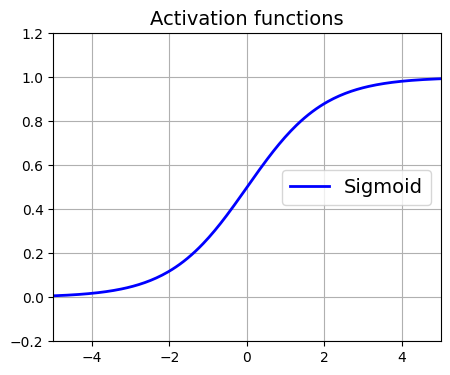

In [3]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, sigmoid(z), "b-", linewidth=2, label="Sigmoid")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])


<body>
    The sigmoid function saturates near 0 and near 1 (y-axis), and is linear between -1 and 1 (x-axis).
</body>

In [4]:
def reset_graph(seed=42):
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.set_random_seed(seed)
    np.random.seed(seed)
    tf.compat.v1.disable_eager_execution()

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

In [6]:
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [7]:
he_init = tf.keras.initializers.variance_scaling()
hidden1 = tf.keras.layers.Dense(n_hidden1,
                                kernel_initializer='he_normal', name='h1')(X)

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

(-5.0, 5.0, -0.5, 4.2)

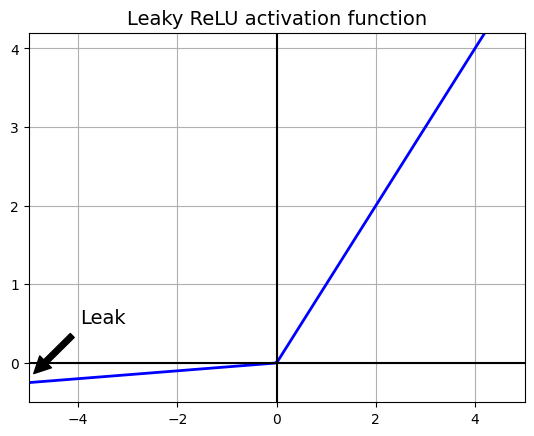

In [9]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

In [10]:
reset_graph()

In [11]:
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [12]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

In [13]:
hidden1 = tf.keras.layers.Dense(n_hidden1, activation=leaky_relu, name="hidden1")(X)

In [14]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [15]:
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.compat.v1.placeholder(tf.int32, shape=(None), name="y")

In [16]:
with tf.name_scope("dnn"):
    hidden1 = tf.keras.layers.Dense(n_hidden1, activation=leaky_relu, name="hidden1")(X)
    hidden2 = tf.keras.layers.Dense(n_hidden2, activation=leaky_relu, name="hidden2")(hidden1)
    logits = tf.keras.layers.Dense(n_outputs, name="outputs")(hidden2)

In [17]:
with tf.name_scope("loss"):
    xentropy = tf.compat.v1.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [18]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [19]:
with tf.name_scope("eval"):
    correct = tf.compat.v1.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [20]:
x = tf.cast(y, dtype=tf.float32)

In [21]:
x.shape

TensorShape(None)

In [22]:
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [24]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [25]:
n_epochs = 40
batch_size = 50

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

2024-03-21 20:31:18.382338: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


0 Batch accuracy: 0.88 Validation accuracy: 0.9016
5 Batch accuracy: 0.94 Validation accuracy: 0.9502
10 Batch accuracy: 0.9 Validation accuracy: 0.965
15 Batch accuracy: 0.92 Validation accuracy: 0.972
20 Batch accuracy: 1.0 Validation accuracy: 0.9748
25 Batch accuracy: 1.0 Validation accuracy: 0.977
30 Batch accuracy: 1.0 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


In [26]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

(-5.0, 5.0, -2.2, 3.2)

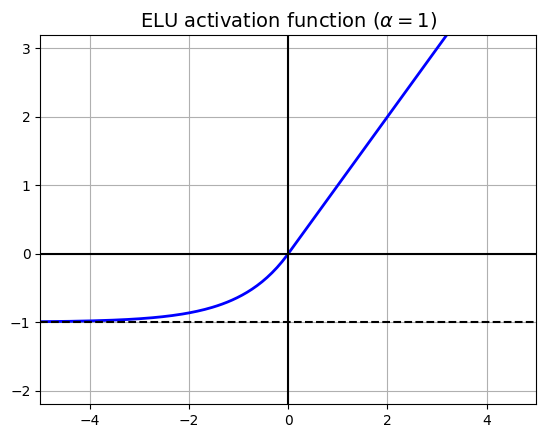

In [27]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

In [28]:
from tensorflow.keras.layers import BatchNormalization

In [29]:
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs= 10

In [30]:
X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs),
    name="X")

In [31]:
is_training = tf.compat.v1.placeholder(
    tf.bool,
    shape=(),
    name="is_training"
)

In [32]:
bn_params = {
    'is_training': is_training,
    'decay': 0.99,
    'updates_collections': None
}

In [33]:
training = tf.compat.v1.placeholder_with_default(False, shape=(), name='training')

<p>hidden1 = tf.keras.layers.Dense(n_hidden1, name="hidden1")(X)
bn1 = BatchNormalization(training=training, momentum=0.9)(hidden1)
bn1_act = tf.nn.elu(bn1)</p>

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

Instructions for updating:
Colocations handled automatically by placer.


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [37]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [47]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
   32/55000 [..............................] - ETA: 3:14 - loss: 3.0814 - accuracy: 0.0625

2024-03-21 21:09:25.137265: W tensorflow/c/c_api.cc:304] Operation '{name:'training/SGD/decay/Assign' id:773 op device:{requested: '', assigned: ''} def:{{{node training/SGD/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/SGD/decay, training/SGD/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


55000/55000 [==============================] - 2s 45us/sample - loss: 0.5476 - accuracy: 0.8100 - val_loss: 0.3889 - val_accuracy: 0.8578
Epoch 2/2
   32/55000 [..............................] - ETA: 5s - loss: 0.4704 - accuracy: 0.8438

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-03-21 21:09:27.539247: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_4/mul' id:530 op device:{requested: '', assigned: ''} def:{{{node loss_4/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_4/mul/x, loss_4/dense_2_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


55000/55000 [==============================] - 2s 43us/sample - loss: 0.4039 - accuracy: 0.8571 - val_loss: 0.3610 - val_accuracy: 0.8722


In [49]:
optimizer = tf.keras.optimizers.legacy.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer)

In [50]:
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
   32/55000 [..............................] - ETA: 5:10 - loss: 0.2429

2024-03-21 21:14:53.483132: W tensorflow/c/c_api.cc:304] Operation '{name:'batch_normalization_2/cond_3/Identity' id:200 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_2/cond_3/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](batch_normalization_2/cond_3)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-03-21 21:14:53.516708: W tensorflow/c/c_api.cc:304] Operation '{name:'training_2/SGD/momentum/Assign' id:1142 op device:{requested: '', assigned: ''} def:{{{node training_2/SGD/momentum/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/SGD/momentum, training_2/SGD/momentum/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will

55000/55000 [==============================] - 3s 50us/sample - loss: 0.3649 - val_loss: 0.3458
Epoch 2/2
   32/55000 [..............................] - ETA: 5s - loss: 0.1866

2024-03-21 21:14:56.091437: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_5/mul' id:895 op device:{requested: '', assigned: ''} def:{{{node loss_5/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_5/mul/x, loss_5/dense_2_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


55000/55000 [==============================] - 3s 46us/sample - loss: 0.3379 - val_loss: 0.3265


In [3]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
pos_class_id = class_names.index("Pullover")
pos_class_id

2

In [5]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

In [6]:
def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

In [7]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [8]:
tf.random.set_seed(42)

In [9]:
model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

In [10]:
model_A.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 8)                 808       
                                                                 
Total params: 99508 (388.70 KB)
Trainable params: 99508 (388.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.SGD(
                    learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1376/1376 [==============================] - 1s 781us/step - loss: 1.1646 - accuracy: 0.6375 - val_loss: 0.6949 - val_accuracy: 0.7804
Epoch 2/20
1376/1376 [==============================] - 1s 702us/step - loss: 0.5982 - accuracy: 0.8080 - val_loss: 0.5045 - val_accuracy: 0.8318
Epoch 3/20
1376/1376 [==============================] - 1s 707us/step - loss: 0.4768 - accuracy: 0.8489 - val_loss: 0.4299 - val_accuracy: 0.8536
Epoch 4/20
1376/1376 [==============================] - 1s 709us/step - loss: 0.4168 - accuracy: 0.8644 - val_loss: 0.3857 - val_accuracy: 0.8666
Epoch 5/20
1376/1376 [==============================] - 1s 699us/step - loss: 0.3806 - accuracy: 0.8745 - val_loss: 0.3606 - val_accuracy: 0.8744
Epoch 6/20
1376/1376 [==============================] - 1s 705us/step - loss: 0.3560 - accuracy: 0.8813 - val_loss: 0.3401 - val_accuracy: 0.8787
Epoch 7/20
1376/1376 [==============================] - 1s 705us/step - loss: 0.3388 - accuracy: 0.8855 - val_loss: 0.3275 -

In [12]:
model_A.save("model_A")

INFO:tensorflow:Assets written to: model_A/assets


INFO:tensorflow:Assets written to: model_A/assets


In [13]:
tf.random.set_seed(42)

In [14]:
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [15]:
model_B.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 98801 (385.94 KB)
Trainable params: 98801 (385.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001),
                metrics=["accuracy"])

In [18]:
history = model_B.fit(X_train_B,
                      y_train_B,
                      epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 17ms/step - loss: 0.7085 - accuracy: 0.4750 - val_loss: 0.6781 - val_accuracy: 0.5312
Epoch 2/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6732 - accuracy: 0.5450 - val_loss: 0.6491 - val_accuracy: 0.6063
Epoch 3/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6425 - accuracy: 0.6250 - val_loss: 0.6229 - val_accuracy: 0.7122
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6125 - accuracy: 0.7250 - val_loss: 0.6019 - val_accuracy: 0.7715
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5901 - accuracy: 0.8000 - val_loss: 0.5813 - val_accuracy: 0.8091
Epoch 6/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5685 - accuracy: 0.8500 - val_loss: 0.5627 - val_accuracy: 0.8467
Epoch 7/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5486 - accuracy: 0.8700 - val_loss: 0.5454 - val_accuracy: 0.8586
Epoch 8/20
7/7 [=================

[0.3991927206516266, 0.9304999709129333]

In [21]:
model_A = tf.keras.models.load_model("model_A")

In [22]:
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])

In [25]:
model_A.layers[:-1]

In [26]:
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [32]:
model_B_on_A.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001),
                metrics=["accuracy"])

In [33]:
model_B_on_A.fit(X_train_B,
                      y_train_B,
                      epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 17ms/step - loss: 0.5620 - accuracy: 0.7250 - val_loss: 0.5143 - val_accuracy: 0.8200
Epoch 2/20
7/7 [==============================] - 0s 6ms/step - loss: 0.4990 - accuracy: 0.8400 - val_loss: 0.4822 - val_accuracy: 0.8586
Epoch 3/20
7/7 [==============================] - 0s 7ms/step - loss: 0.4701 - accuracy: 0.8700 - val_loss: 0.4661 - val_accuracy: 0.8665
Epoch 4/20
7/7 [==============================] - 0s 6ms/step - loss: 0.4370 - accuracy: 0.8900 - val_loss: 0.4363 - val_accuracy: 0.8942
Epoch 5/20
7/7 [==============================] - 0s 6ms/step - loss: 0.4122 - accuracy: 0.9100 - val_loss: 0.4126 - val_accuracy: 0.9031
Epoch 6/20
7/7 [==============================] - 0s 6ms/step - loss: 0.3909 - accuracy: 0.9050 - val_loss: 0.3932 - val_accuracy: 0.9080
Epoch 7/20
7/7 [==============================] - 0s 6ms/step - loss: 0.3710 - accuracy: 0.9250 - val_loss: 0.3842 - val_accuracy: 0.8981
Epoch 8/20
7/7 [=================

In [34]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 585us/step - loss: 0.2727 - accuracy: 0.9350


[0.2726621627807617, 0.9350000023841858]

In [35]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [40]:
model_A.get_weights()[0][0][0]

-0.04366996

In [43]:
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [44]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [46]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 0s 17ms/step - loss: 0.8832 - accuracy: 0.5450 - val_loss: 0.6325 - val_accuracy: 0.7211
Epoch 2/16
7/7 [==============================] - 0s 6ms/step - loss: 0.6465 - accuracy: 0.7200 - val_loss: 0.5615 - val_accuracy: 0.7705
Epoch 3/16
7/7 [==============================] - 0s 6ms/step - loss: 0.5933 - accuracy: 0.7600 - val_loss: 0.5449 - val_accuracy: 0.7349
Epoch 4/16
7/7 [==============================] - 0s 6ms/step - loss: 0.5713 - accuracy: 0.7450 - val_loss: 0.5376 - val_accuracy: 0.7349
Epoch 5/16
7/7 [==============================] - 0s 6ms/step - loss: 0.5618 - accuracy: 0.7400 - val_loss: 0.5245 - val_accuracy: 0.7478
Epoch 6/16
7/7 [==============================] - 0s 6ms/step - loss: 0.5461 - accuracy: 0.7450 - val_loss: 0.5117 - val_accuracy: 0.7745
Epoch 7/16
7/7 [==============================] - 0s 6ms/step - loss: 0.5333 - accuracy: 0.7650 - val_loss: 0.5019 - val_accuracy: 0.8022
Epoch 8/16
7/7 [=================

In [49]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 572us/step - loss: 0.4460 - accuracy: 0.8245


[0.44598084688186646, 0.8245000243186951]

In [50]:
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(100, activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dense(10, activation="softmax")
    ])

In [51]:
def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
        validation_data=(X_valid, y_valid))

In [52]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001,
                                           momentum=0.9)

In [53]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 1s 769us/step - loss: 0.7208 - accuracy: 0.7565 - val_loss: 0.5186 - val_accuracy: 0.8178
Epoch 2/10
1719/1719 [==============================] - 1s 701us/step - loss: 0.4876 - accuracy: 0.8301 - val_loss: 0.4617 - val_accuracy: 0.8328
Epoch 3/10
1719/1719 [==============================] - 1s 717us/step - loss: 0.4452 - accuracy: 0.8439 - val_loss: 0.4363 - val_accuracy: 0.8438
Epoch 4/10
1719/1719 [==============================] - 1s 709us/step - loss: 0.4201 - accuracy: 0.8539 - val_loss: 0.4037 - val_accuracy: 0.8546
Epoch 5/10
1719/1719 [==============================] - 1s 705us/step - loss: 0.4002 - accuracy: 0.8607 - val_loss: 0.3920 - val_accuracy: 0.8584
Epoch 6/10
1719/1719 [==============================] - 1s 694us/step - loss: 0.3879 - accuracy: 0.8635 - val_loss: 0.3937 - val_accuracy: 0.8610
Epoch 7/10
1719/1719 [==============================] - 1s 700us/step - loss: 0.3721 - accuracy: 0.8678 - val_loss: 0.3822 -

<h3>
    Momentum optimization
</h3>

In [54]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001,
                                           momentum=0.9)

In [55]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 1s 786us/step - loss: 0.7282 - accuracy: 0.7571 - val_loss: 0.5230 - val_accuracy: 0.8178
Epoch 2/10
1719/1719 [==============================] - 1s 739us/step - loss: 0.4913 - accuracy: 0.8303 - val_loss: 0.4628 - val_accuracy: 0.8368
Epoch 3/10
1719/1719 [==============================] - 1s 738us/step - loss: 0.4479 - accuracy: 0.8434 - val_loss: 0.4375 - val_accuracy: 0.8450
Epoch 4/10
1719/1719 [==============================] - 1s 739us/step - loss: 0.4210 - accuracy: 0.8529 - val_loss: 0.4042 - val_accuracy: 0.8564
Epoch 5/10
1719/1719 [==============================] - 1s 732us/step - loss: 0.4008 - accuracy: 0.8598 - val_loss: 0.3896 - val_accuracy: 0.8584
Epoch 6/10
1719/1719 [==============================] - 1s 737us/step - loss: 0.3868 - accuracy: 0.8643 - val_loss: 0.3912 - val_accuracy: 0.8620
Epoch 7/10
1719/1719 [==============================] - 1s 732us/step - loss: 0.3703 - accuracy: 0.8699 - val_loss: 0.3824 -

<h3>
    Nesterov Accelerated Gradient
</h3>

In [58]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [59]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 1s 783us/step - loss: 0.7099 - accuracy: 0.7648 - val_loss: 0.5092 - val_accuracy: 0.8178
Epoch 2/10
1719/1719 [==============================] - 1s 726us/step - loss: 0.4764 - accuracy: 0.8356 - val_loss: 0.4514 - val_accuracy: 0.8386
Epoch 3/10
1719/1719 [==============================] - 1s 719us/step - loss: 0.4335 - accuracy: 0.8500 - val_loss: 0.4161 - val_accuracy: 0.8522
Epoch 4/10
1719/1719 [==============================] - 1s 712us/step - loss: 0.4082 - accuracy: 0.8593 - val_loss: 0.3966 - val_accuracy: 0.8566
Epoch 5/10
1719/1719 [==============================] - 1s 705us/step - loss: 0.3891 - accuracy: 0.8644 - val_loss: 0.3821 - val_accuracy: 0.8610
Epoch 6/10
1719/1719 [==============================] - 1s 712us/step - loss: 0.3762 - accuracy: 0.8685 - val_loss: 0.3961 - val_accuracy: 0.8574
Epoch 7/10
1719/1719 [==============================] - 1s 722us/step - loss: 0.3625 - accuracy: 0.8714 - val_loss: 0.3768 -

<h3>
    AdaGrad
</h3>

In [60]:
optimizer = tf.keras.optimizers.legacy.Adagrad(learning_rate=0.001)

In [62]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 1s 782us/step - loss: 1.0534 - accuracy: 0.6636 - val_loss: 0.7338 - val_accuracy: 0.7602
Epoch 2/10
1719/1719 [==============================] - 1s 720us/step - loss: 0.6879 - accuracy: 0.7738 - val_loss: 0.6281 - val_accuracy: 0.7906
Epoch 3/10
1719/1719 [==============================] - 1s 730us/step - loss: 0.6148 - accuracy: 0.7981 - val_loss: 0.5788 - val_accuracy: 0.8076
Epoch 4/10
1719/1719 [==============================] - 1s 719us/step - loss: 0.5752 - accuracy: 0.8105 - val_loss: 0.5500 - val_accuracy: 0.8150
Epoch 5/10
1719/1719 [==============================] - 1s 724us/step - loss: 0.5491 - accuracy: 0.8173 - val_loss: 0.5295 - val_accuracy: 0.8216
Epoch 6/10
1719/1719 [==============================] - 1s 726us/step - loss: 0.5302 - accuracy: 0.8243 - val_loss: 0.5145 - val_accuracy: 0.8278
Epoch 7/10
1719/1719 [==============================] - 1s 715us/step - loss: 0.5155 - accuracy: 0.8282 - val_loss: 0.5015 -

<h3>
    RMSProp
</h3>

In [66]:
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001, rho=0.9)

In [67]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 979us/step - loss: 0.5053 - accuracy: 0.8196 - val_loss: 0.4080 - val_accuracy: 0.8438
Epoch 2/10
1719/1719 [==============================] - 2s 938us/step - loss: 0.3840 - accuracy: 0.8616 - val_loss: 0.4060 - val_accuracy: 0.8496
Epoch 3/10
1719/1719 [==============================] - 2s 916us/step - loss: 0.3578 - accuracy: 0.8724 - val_loss: 0.3640 - val_accuracy: 0.8722
Epoch 4/10
1719/1719 [==============================] - 2s 902us/step - loss: 0.3490 - accuracy: 0.8783 - val_loss: 0.3862 - val_accuracy: 0.8714
Epoch 5/10
1719/1719 [==============================] - 2s 911us/step - loss: 0.3413 - accuracy: 0.8811 - val_loss: 0.3804 - val_accuracy: 0.8664
Epoch 6/10
1719/1719 [==============================] - 2s 910us/step - loss: 0.3329 - accuracy: 0.8852 - val_loss: 0.4602 - val_accuracy: 0.8626
Epoch 7/10
1719/1719 [==============================] - 2s 900us/step - loss: 0.3299 - accuracy: 0.8865 - val_loss: 0.3903 -

<h3>
    Adam Optimization
</h3>

In [68]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [69]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 894us/step - loss: 0.4933 - accuracy: 0.8243 - val_loss: 0.4361 - val_accuracy: 0.8334
Epoch 2/10
1719/1719 [==============================] - 1s 842us/step - loss: 0.3686 - accuracy: 0.8663 - val_loss: 0.4113 - val_accuracy: 0.8406
Epoch 3/10
1719/1719 [==============================] - 1s 843us/step - loss: 0.3355 - accuracy: 0.8763 - val_loss: 0.3498 - val_accuracy: 0.8762
Epoch 4/10
1719/1719 [==============================] - 1s 834us/step - loss: 0.3090 - accuracy: 0.8868 - val_loss: 0.3386 - val_accuracy: 0.8776
Epoch 5/10
1719/1719 [==============================] - 1s 843us/step - loss: 0.2940 - accuracy: 0.8914 - val_loss: 0.3167 - val_accuracy: 0.8822
Epoch 6/10
1719/1719 [==============================] - 1s 840us/step - loss: 0.2796 - accuracy: 0.8960 - val_loss: 0.3349 - val_accuracy: 0.8832
Epoch 7/10
1719/1719 [==============================] - 1s 832us/step - loss: 0.2684 - accuracy: 0.8991 - val_loss: 0.3497 -

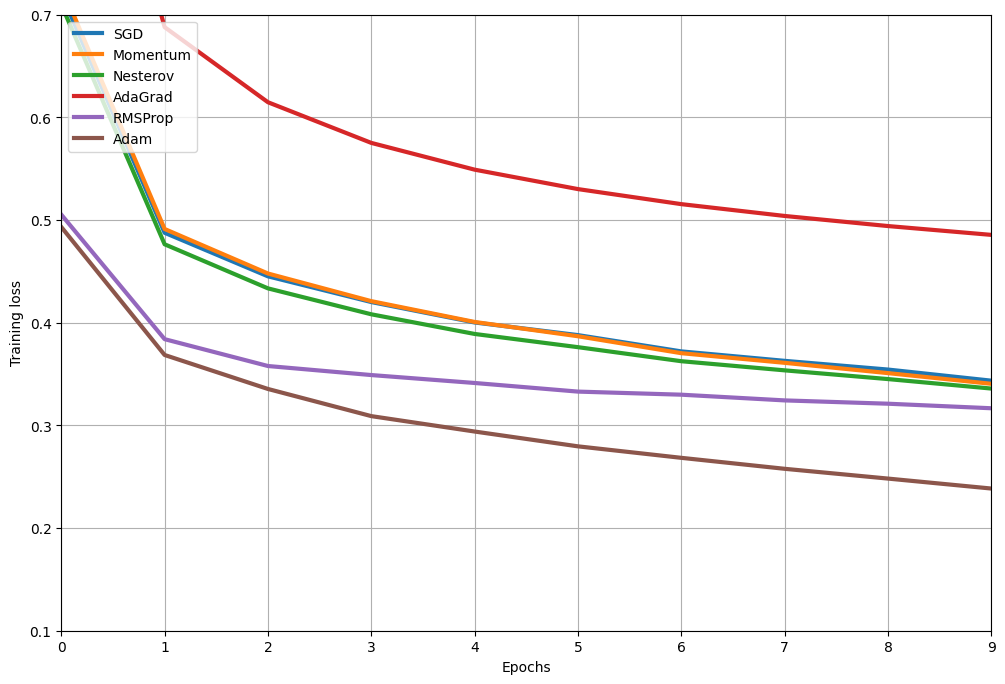

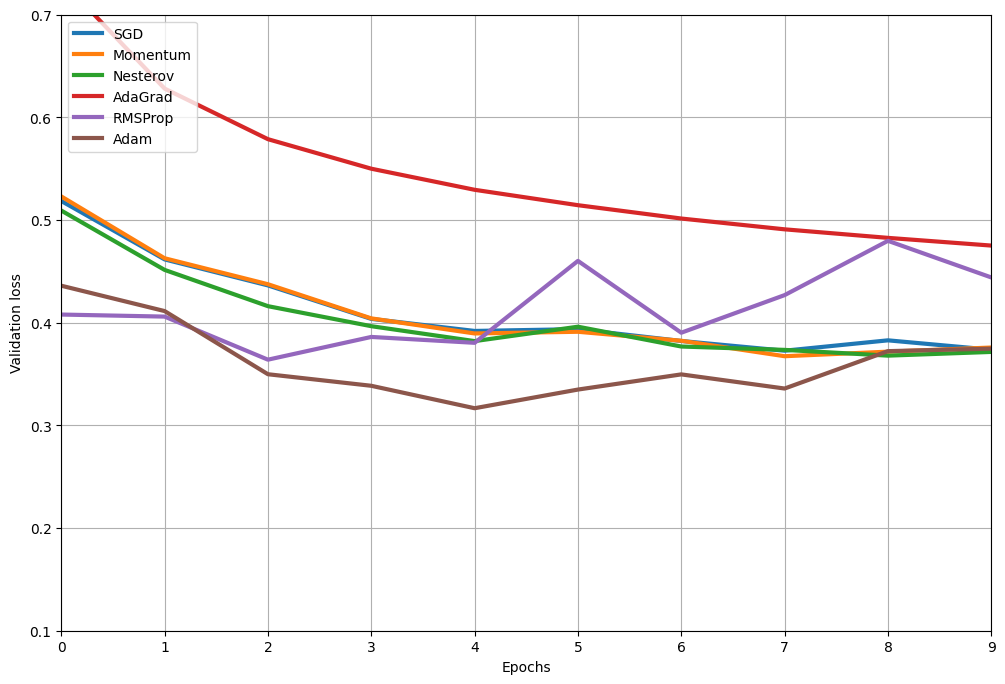

In [70]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()